In [1]:
"""
Grid-search models on a selection of extracted audio features.
""";

In [2]:
import MTheory as mt
import imlearn 

In [3]:
import pandas as pd
import numpy as np
import pickle
import os
import time

In [4]:
import librosa

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, decomposition

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
main_path = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Music/'

music_universe = {'Bach': ['Art_of_Fugue','Goldberg_Variations','Partitas','Sinfonia','Two_Part_Inventions','WTC1','WTC2','Other'],
                  'Mozart': ['Sonatas','Sonatinas','Fugue','Variations','Other']}

df_filename = '/Users/ilanmoscovitz/github/sf18_ds11/projects/03-mcnulty/Raw_Arrays.pkl'
extraction_keys = ['y','sr','y_harmonic','y_percussive','chroma', 'sparse']

In [8]:
def elapsed(end,start):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    seconds=int(seconds)
    
    result = ''
    if hours: result += str(int(hours))+':'
    if minutes: 
        result += str(int(minutes))+':'
    else:
        result = ':'
    result+=str(seconds)
    
    return result

In [9]:
def slice_jar_pickle(main_path, destination_dir):
    """
    Uses my MTheory::Sample objects to build, split, and pickle a broad range of audio data
    into 30-second clip examples.
    
    Overwrites the clips, but tries to save and reuse as much of the data as possible
    the larger Samples have already extracted and computed to save time.
    """
    
    count = 0

    start_time = time.time()
    for composer, collections in music_universe.items():
        for collection in collections:
            collection_dir = main_path + composer + '/' + collection + '/'
            print(collection_dir)
            songs = [song_file[:-4] for song_file in os.listdir(collection_dir) if song_file.endswith('.mp3')]
            for song in songs:
                    
                # Collect audio data in an mt.Sample object
                audio_path = main_path + composer + '/' + collection + '/' + song + '.mp3'
                sample_path = audio_path.split('.')[0]+'_sample.pkl'
                print(sample_path)

                # Autoload, if applicable
                sample = mt.try_get_pickle(sample_path)
                if not sample:
                    extractions = mt.load_or_parse(audio_path)
                    idee = {'Composer':composer,'Collection':collection,'Song':song}
                    sample = mt.Sample(extractions, idee)
                
                # Think of the children!
                # Process mt harmonic information on the parent now so the children have it for later 
                sample.try_build_tonality_matches()
                
                # Save song sample
                sample.to_pickle(sample_path)
                
                # Split each Sample object into 30 second chunks
                examples = sample.split(seconds=30)
                
                # Index each chunk and dump everything into one folder
                for i, example in enumerate(examples):
                    destination = destination_dir + 'example_' + str(count) + '.pkl'
                    example.to_pickle(destination)
                    count += 1
                
                # Update user output
                current_time = time.time()
                print('Example',count,elapsed(current_time,start_time))
                    
                    
    end_time = time.time()
    print('\ntotal minutes:',elapsed(end_time,start_time))

In [10]:
examples_path = main_path + 'Samples/'
#slice_jar_pickle(main_path, examples_path)

In [11]:
# Number of examples produced:
len(os.listdir(examples_path))

1403

In [12]:
# Here's what the pickled Sample objects have extracted:
sample = mt.get_pickle(main_path+'Samples/example_6.pkl')

In [13]:
# Sample identification
sample.idee

{'Collection': 'Art_of_Fugue',
 'Composer': 'Bach',
 'Snippet': (2, 8),
 'Song': 'can3'}

In [14]:
# Five audio matrices produced per example
# (The first one, 'chroma', is the data we used for the first modeling group)

sample.base

{'chroma': array([[1.        , 1.        , 1.        , ..., 0.11832721, 0.10491937,
         0.07662463],
        [0.53693536, 0.54338637, 0.51749766, ..., 0.58274399, 0.43752178,
         0.50710063],
        [0.05554909, 0.05850869, 0.04405304, ..., 1.        , 1.        ,
         1.        ],
        ...,
        [0.08771775, 0.09045134, 0.09123563, ..., 0.13310335, 0.14389357,
         0.12423556],
        [0.05983207, 0.05112803, 0.0568623 , ..., 0.09708558, 0.08245821,
         0.08504777],
        [0.52429438, 0.51767883, 0.5329561 , ..., 0.08702343, 0.07841974,
         0.06283905]]),
 'sparse': array([[1.        , 1.        , 1.        , ..., 0.08896934, 0.10202464,
         0.11166184],
        [0.03663083, 0.03529356, 0.03669496, ..., 0.27691009, 0.34055451,
         0.47182497],
        [0.03898083, 0.04591423, 0.05504341, ..., 1.        , 1.        ,
         1.        ],
        ...,
        [0.07985796, 0.07969138, 0.08630971, ..., 0.12197376, 0.12412198,
         0.123

In [15]:
# Now we need to feature engineer a df from the extracted data in those 1400 examples

In [16]:
def get_tempo(y, sr, hop_length=512):
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                               hop_length=hop_length)[0]
    return int(tempo)

In [17]:
def get_spectral_centroid(y, sr):
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    sc_range = np.max(cent) - np.min(cent)
    return int(sc_range)

In [18]:
def get_spectral_contrast(y, sr):
    S = np.abs(librosa.stft(y))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    return contrast

In [19]:
def add_example(df, sample):
    
    # Collect extractions
    y = sample.base['y']
    sr = sample.base['sr']
    chroma = sample.base['chroma']

    # Idee
    idee = {'Composer':sample.idee['Composer'],
            'Collection':sample.idee['Collection'],
            'Song':sample.idee['Song'],
            'Snippet':sample.idee['Snippet']}
    
    # Collect simple features
    tempo = get_tempo(y, sr)
    sc_range = get_spectral_centroid(y, sr)
    contrast = get_spectral_contrast(y, sr)
    contrast_mean = np.mean(contrast, axis=1)
    contrast_var = np.var(contrast, axis=1)
    
    # Add features to df
    features = {'Tempo':tempo,
                'SCentr_Range':sc_range}

    for band in range(len(contrast_mean)):
        features['SContr_mean'+str(band)] = contrast_mean[band]
    for band in range(len(contrast_var)):
        features['SContr_var'+str(band)] = contrast_var[band]
                
    to_add = idee.copy()
    to_add.update(features)
    df = df.append(to_add, ignore_index=True)
    return df

In [20]:
def cols_to_front(df, front_cols):
    cols = list(df)
    for col in reversed(front_cols):
        cols.insert(0, cols.pop(cols.index(col)))
    return df[cols]

In [21]:
def make_df(examples_path):
    df = pd.DataFrame()
    sample_filenames = os.listdir(examples_path)
    
    count = 1
    for sample_filename in sample_filenames:
        if 'example' in sample_filename: 
            sample = mt.get_pickle(examples_path+sample_filename)
            df = add_example(df, sample)
        if not count%100: 
            print('Example', count, 'of', len(sample_filenames))
        count+=1
        
    front_cols = ['Composer', 'Collection', 'Song', 'Snippet', 'Tempo']
    df = cols_to_front(df, front_cols)
    
    return df

In [22]:
#df = make_df(examples_path)

In [23]:
#df.head()

In [24]:
# Pickle it
#pickle.dump(df,open('Audio_Feature_df.pkl','wb'))

In [25]:
df = pd.read_pickle('Audio_Feature_df.pkl')

In [26]:
# Custom train-test split
train, test = imlearn.custom_train_test_split(df, 'Song', test_size=0.3, random_seed=50)

In [27]:
# Hide cheating attributes during training
omit_mask = ['Collection','Song','Snippet']

In [28]:
# Train using CustomGridCV

models = [('svm',svm.SVC),
          ('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(-3,3,6),
        'gamma': np.logspace(-3,3,6)
    },
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.7468893450441444
svm: best params: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}

knn: best score: 0.6891970546535178
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.7733791430079331
logistic: best params: {'C': 0.2848035868435802, 'penalty': 'l1'}

tree: best score: 0.7960699893827021
tree: best params: {'max_depth': 2, 'min_samples_leaf': 3}

forest: best score: 0.8071138560635054
forest: best params: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}



In [32]:
# SVM and Random Forest went off the grid. 
# Search those two again with expanded grid boundries

models = [('svm',svm.SVC),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(-6,6,12),
        'gamma': np.logspace(-6,6,12)
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5,6,7,8,9,10],
        'min_samples_leaf': [3,6,10,13,16,20]
    }
]

grids2 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=True)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids2[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 1e-06, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 1.2328467394420658e-05, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 0.0001519911082952933, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 0.001873817422860383, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 0.02310129700083158, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 0.2848035868435799, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 3.5111917342151275, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 43.287612810830524, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 533.6699231206302, 'kernel': 'rbf'}

validation score: 0.3840669681805179
grid: {'C': 1e-06, 'gamma': 6579.3322465

validation score: 0.5347899732172889
grid: {'C': 3.5111917342151275, 'gamma': 1e-06, 'kernel': 'rbf'}

validation score: 0.7034836954282631
grid: {'C': 3.5111917342151275, 'gamma': 1.2328467394420658e-05, 'kernel': 'rbf'}

validation score: 0.7497019952240541
grid: {'C': 3.5111917342151275, 'gamma': 0.0001519911082952933, 'kernel': 'rbf'}

validation score: 0.7217598907174867
grid: {'C': 3.5111917342151275, 'gamma': 0.001873817422860383, 'kernel': 'rbf'}

validation score: 0.6159277501451818
grid: {'C': 3.5111917342151275, 'gamma': 0.02310129700083158, 'kernel': 'rbf'}

validation score: 0.602989463286216
grid: {'C': 3.5111917342151275, 'gamma': 0.2848035868435799, 'kernel': 'rbf'}

validation score: 0.602989463286216
grid: {'C': 3.5111917342151275, 'gamma': 3.5111917342151275, 'kernel': 'rbf'}

validation score: 0.602989463286216
grid: {'C': 3.5111917342151275, 'gamma': 43.287612810830524, 'kernel': 'rbf'}

validation score: 0.602989463286216
grid: {'C': 3.5111917342151275, 'gamma': 5

validation score: 0.7005307410049407
grid: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}

validation score: 0.7092442684023365
grid: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 100}

validation score: 0.7111396221443305
grid: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 200}

validation score: 0.6984678189586478
grid: {'max_depth': 1, 'min_samples_leaf': 6, 'n_estimators': 50}

validation score: 0.6978085034714556
grid: {'max_depth': 1, 'min_samples_leaf': 6, 'n_estimators': 100}

validation score: 0.7137719682427942
grid: {'max_depth': 1, 'min_samples_leaf': 6, 'n_estimators': 200}

validation score: 0.7008070718710984
grid: {'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 50}

validation score: 0.7050094737234472
grid: {'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 100}

validation score: 0.7136589194878817
grid: {'max_depth': 1, 'min_samples_leaf': 10, 'n_estimators': 200}

validation score: 0.693419950602286
grid: {'max_depth':

validation score: 0.7890214533004645
grid: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}

validation score: 0.7930331375329598
grid: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}

validation score: 0.7969792336130969
grid: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}

validation score: 0.7882865597842872
grid: {'max_depth': 5, 'min_samples_leaf': 13, 'n_estimators': 50}

validation score: 0.7930365274985381
grid: {'max_depth': 5, 'min_samples_leaf': 13, 'n_estimators': 100}

validation score: 0.7992792133779794
grid: {'max_depth': 5, 'min_samples_leaf': 13, 'n_estimators': 200}

validation score: 0.7911126440293261
grid: {'max_depth': 5, 'min_samples_leaf': 16, 'n_estimators': 50}

validation score: 0.7873573084309731
grid: {'max_depth': 5, 'min_samples_leaf': 16, 'n_estimators': 100}

validation score: 0.794953342622278
grid: {'max_depth': 5, 'min_samples_leaf': 16, 'n_estimators': 200}

validation score: 0.7837951648252466
grid: {'max_d

validation score: 0.8120997336228617
grid: {'max_depth': 9, 'min_samples_leaf': 16, 'n_estimators': 50}

validation score: 0.8081426773339601
grid: {'max_depth': 9, 'min_samples_leaf': 16, 'n_estimators': 100}

validation score: 0.8070794987662427
grid: {'max_depth': 9, 'min_samples_leaf': 16, 'n_estimators': 200}

validation score: 0.8003184547968741
grid: {'max_depth': 9, 'min_samples_leaf': 20, 'n_estimators': 50}

validation score: 0.8023717196370903
grid: {'max_depth': 9, 'min_samples_leaf': 20, 'n_estimators': 100}

validation score: 0.7976051596564024
grid: {'max_depth': 9, 'min_samples_leaf': 20, 'n_estimators': 200}

validation score: 0.820991134985165
grid: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}

validation score: 0.8444999321570519
grid: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}

validation score: 0.8435482515686159
grid: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}

validation score: 0.821738107819621
grid: {'max_de

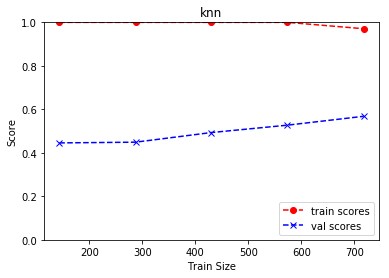

In [34]:
# None of them seem to be overfitting.

imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids['knn'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="knn")

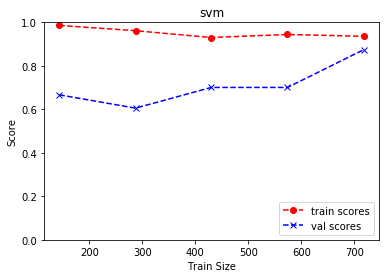

In [35]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids2['svm'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="svm")

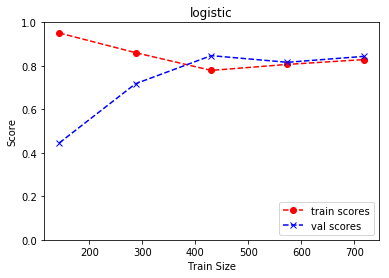

In [36]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids['logistic'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="logistic")

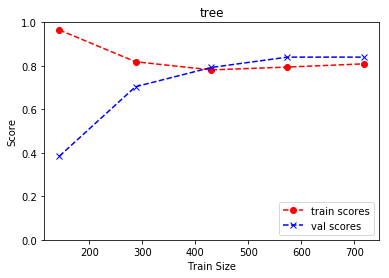

In [37]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids['tree'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="tree")

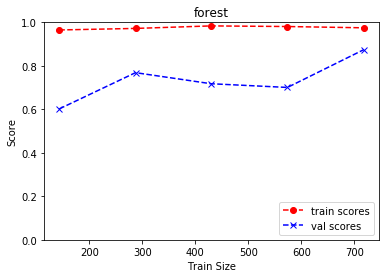

In [38]:
imlearn.draw_learning_curve(train, y_feat='Composer', split_on='Song', clf=grids2['forest'].best_model_, cv=5, omit_mask=omit_mask, random_seed=42, title="forest")

In [ ]:
# Best params:

"""
svm: best score: 0.8618923661311694
svm: best params: {'C': 6579.3322465756555, 'gamma': 1e-06, 'kernel': 'rbf'}

knn: best score: 0.6891970546535178
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.7733791430079331
logistic: best params: {'C': 0.2848035868435802, 'penalty': 'l1'}

tree: best score: 0.7960699893827021
tree: best params: {'max_depth': 2, 'min_samples_leaf': 3}

forest: best score: 0.8444999321570519
forest: best params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
""";

In [39]:
# Second pass: Zooming in grid search with deeper resolution (where applicable)

models = [('svm',svm.SVC),
          ('logistic', LogisticRegression),
         ]

param_choices = [
    {
        'kernel': ['rbf'],
        'C': np.linspace(6000,7000,10),
        'gamma': np.logspace(-1e-07,-1e-06,10)
    },
    {
        'C': np.linspace(1,.1, 10),
        'penalty': ['l1', 'l2']
    }
]

grids3 = {}
grid_predictions = {}
grid_actuals = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = imlearn.CustomGridCV(clf=model(), params=params, fold_on='Song')
    grid.fit_score(train, y_feat='Composer', omit_mask=omit_mask, random_seed=42, display=False)
    s = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best params: {grid.best_parameters_}"
    print(s)
    print(p)
    print()
    grids3[name] = grid
    grid_predictions[name],grid_actuals[name] = grid.best_predictions_actuals_

svm: best score: 0.602989463286216
svm: best params: {'C': 6000.0, 'gamma': 0.9999997697415172, 'kernel': 'rbf'}

logistic: best score: 0.773799669980796
logistic: best params: {'C': 1.0, 'penalty': 'l2'}



In [ ]:
# Besties:

"""
svm: best score: 0.8618923661311694
svm: best params: {'C': 6579.3322465756555, 'gamma': 1e-06, 'kernel': 'rbf'}

knn: best score: 0.6891970546535178
knn: best params: {'n_neighbors': 1}

logistic: best score: 0.773799669980796
logistic: best params: {'C': 1.0, 'penalty': 'l2'}

tree: best score: 0.7960699893827021
tree: best params: {'max_depth': 2, 'min_samples_leaf': 3}

forest: best score: 0.8444999321570519
forest: best params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
""";

In [ ]:
train.to_pickle('Audio_Feature_train.pkl')
test.to_pickle('Audio_Feature_test.pkl')